In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'
DATA_PATH_BYD = '../bds/BYDDY.csv'


In [2]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [4]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

significantLags: [1, 5, 8, 10, 19, 25, 45, 47, 50, 57, 64, 68]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10),(Close-19),(Close-25),(Close-45),(Close-47),(Close-50),(Close-57),(Close-64),(Close-68)
68,2020-12-08,216.626663,213.919998,194.919998,191.333328,173.949997,136.786667,133.503326,141.893326,149.386673,140.399994,141.143326,110.07000,158.350006
69,2020-12-09,201.493332,216.626663,189.606674,195.253326,185.126663,139.043335,141.300003,137.993332,138.363327,139.690002,147.383331,122.09333,149.123337


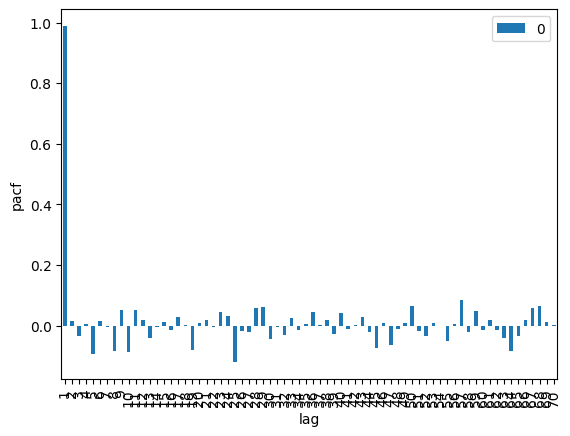

In [5]:
tesla_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 70, alpha=0.05)

TM_tesla = appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [6]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X = df_tesla.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df_tesla['Close']
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
def sliding_window_cross_validation(X, y, window_size, test_size, params):
    """
    Realiza validação cruzada com janela deslizante para uma árvore de decisão.

    Args:
        X (pd.DataFrame): As variáveis preditoras.
        y (pd.Series): A variável dependente.
        window_size (int): Tamanho da janela de treino.
        test_size (int): Tamanho da janela de teste.

    Returns:
        dict: Um dicionário com as previsões e o erro médio quadrático.
    """
    predictions = []
    actuals = []

    max_depth, min_samples_split, min_samples_leaf, max_features  = params

    # Loop sobre os dados com a janela deslizante
    for start in range(0, len(y) - window_size - test_size + 1):
        # Definir a janela de treino e teste
        X_train = X.iloc[start:start + window_size]
        y_train = y.iloc[start:start + window_size]
        X_test = X.iloc[start + window_size:start + window_size + test_size]
        y_test = y.iloc[start + window_size:start + window_size + test_size]

        # Criar e treinar o modelo de árvore de decisão
        model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
        )
        model.fit(X_train, y_train)

        # Fazer previsões
        y_pred = model.predict(X_test)

        # Armazenar as previsões e os valores reais
        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Calcular o erro médio quadrático
    mse = mean_squared_error(actuals, predictions)

    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse
    }

In [9]:
def rolling_window_cross_validation(X, y, train_size, test_size, params):
    """
    Realiza validação cruzada com rolling window para uma árvore de decisão.

    Args:
        X (pd.DataFrame): As variáveis preditoras.
        y (pd.Series): A variável dependente.
        train_size (int): Tamanho da janela de treino.
        test_size (int): Tamanho da janela de teste.
        params (tuple): Parâmetros para a árvore de decisão (max_depth, min_samples_split, min_samples_leaf, max_features).

    Returns:
        dict: Um dicionário com as previsões e o erro médio quadrático.
    """
    predictions = []
    actuals = []

    max_depth, min_samples_split, min_samples_leaf, max_features = params

    # Loop sobre os dados com a janela rolante
    for start in range(0, len(y) - train_size - test_size + 1):
        # Definir a janela de treino e teste
        X_train = X.iloc[start:start + train_size]
        y_train = y.iloc[start:start + train_size]
        X_test = X.iloc[start + train_size:start + train_size + test_size]
        y_test = y.iloc[start + train_size:start + train_size + test_size]

        # Criar e treinar o modelo de árvore de decisão
        model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
        )
        model.fit(X_train, y_train)

        # Fazer previsões
        y_pred = model.predict(X_test)

        # Armazenar as previsões e os valores reais
        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Calcular o erro médio quadrático
    mse = mean_squared_error(actuals, predictions)

    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse
    }

O blocked cross-validation é uma técnica que ignora dados adjacentes entre a janela de treino e a de teste para evitar o efeito de autocorrelação (contaminação entre treino e teste).

Esse método é útil se há uma forte dependência temporal entre dados próximos, onde uma janela de "buffer" é deixada entre os conjuntos de treino e teste, ajudando a garantir uma maior independência entre os dois.

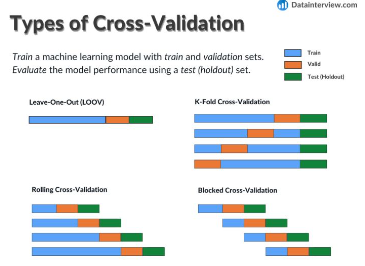

In [10]:
def blocked_cross_validation(X, y, train_size, test_size, buffer_size, params):
    """
    Realiza validação cruzada com Blocked Cross-Validation para uma árvore de decisão,
    utilizando uma janela de buffer entre os dados de treino e teste.

    Args:
        X (pd.DataFrame): As variáveis preditoras.
        y (pd.Series): A variável dependente.
        train_size (int): Tamanho da janela de treino.
        test_size (int): Tamanho da janela de teste.
        buffer_size (int): Tamanho da janela de buffer entre treino e teste.
        params (tuple): Parâmetros para a árvore de decisão (max_depth, min_samples_split, min_samples_leaf, max_features).

    Returns:
        dict: Um dicionário com as previsões e o erro médio quadrático.
    """
    predictions = []
    actuals = []

    max_depth, min_samples_split, min_samples_leaf, max_features = params

    # Loop sobre os dados com a janela bloqueada
    for start in range(0, len(y) - train_size - buffer_size - test_size + 1):
        # Definir a janela de treino
        X_train = X.iloc[start:start + train_size]
        y_train = y.iloc[start:start + train_size]

        # Definir a janela de teste após o buffer
        X_test = X.iloc[start + train_size + buffer_size:start + train_size + buffer_size + test_size]
        y_test = y.iloc[start + train_size + buffer_size:start + train_size + buffer_size + test_size]

        # Criar e treinar o modelo de árvore de decisão
        model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
        )
        model.fit(X_train, y_train)

        # Fazer previsões
        y_pred = model.predict(X_test)

        # Armazenar as previsões e os valores reais
        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Calcular o erro médio quadrático
    mse = mean_squared_error(actuals, predictions)

    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse
    }

In [11]:
window_size=60
test_size=20
def objective(params):
    
    results = sliding_window_cross_validation(X_train_tesla, y_train_tesla, window_size, test_size, params)
    return results['mse']

In [12]:
from skopt.space import Real, Integer

In [13]:
space = [
    Integer(1, 50, name='max_depth'),                # profundidade máxima da árvore
    Integer(2, 50, name='min_samples_split'),         # mínimo de amostras para dividir um nó
    Integer(1, 50, name='min_samples_leaf'),           # mínimo de amostras em um nó folha            
    Real(0.1, 1.0, name='max_features'),                # fração de características a serem consideradas
]

In [14]:
from skopt import gp_minimize

In [ ]:
# estudar o processo gaussiano

In [15]:
# Executando a busca bayesiana
start_time = time.time()
res = gp_minimize(objective, space, n_calls=50, random_state=42)
end_time = time.time()
execution_time1 = end_time - start_time
print(f"Tempo de execução: {execution_time1} segundos")

Tempo de execução: 141.9838433265686 segundos


In [16]:
best_max_depth = int(res.x[0])
best_min_samples_split = int(res.x[1])
best_min_samples_leaf = int(res.x[2])
best_max_features = res.x[3]

print("Melhores hiperparâmetros encontrados:")
print(f"Max Depth: {best_max_depth}")
print(f"Min Samples Split: {best_min_samples_split}")
print(f"Min Samples Leaf: {best_min_samples_leaf}")
print(f"Max Features: {best_max_features}")

Melhores hiperparâmetros encontrados:
Max Depth: 38
Min Samples Split: 2
Min Samples Leaf: 4
Max Features: 1.0


In [17]:
best_model = DecisionTreeRegressor(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features
)

best_model.fit(X_train_tesla, y_train_tesla)

# Fazer previsões com o melhor modelo
y_best_pred = best_model.predict(X_test_tesla)

In [18]:
calcular_metricas_regressao(y_test_tesla, y_best_pred)

,Métrica,Valor
0,MAE,7.020459
1,MSE,87.160783
2,MAPE,0.034936
3,RMSE,9.335994
4,R²,0.901655
5,THEIL,1.744730
6,ARV,0.098345
7,WPOCID,0.315508


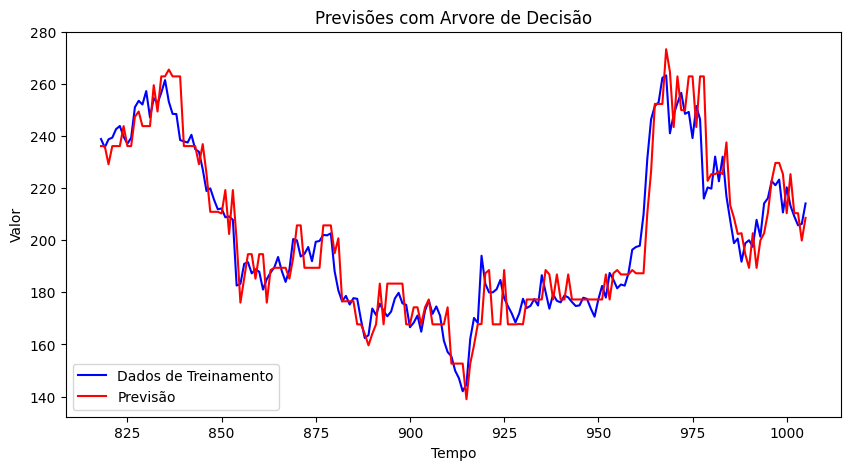

In [19]:
X_test_index = X_test_tesla.index

# Visualizando as previsões
plt.figure(figsize=(10, 5))
plt.plot(X_test_index , y_test_tesla, label='Dados de Treinamento', color='blue')
plt.plot(X_test_index , y_best_pred, label='Previsão', color='red')
plt.title('Previsões com Arvore de Decisão')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

residuo do randowm walk -> prever ele

In [20]:
import pickle

caminho_arquivo = 'modelos/modelo_arvore_regressor_melhor_ajustado.pkl'

# Salvar o modelo
with open(caminho_arquivo, 'wb') as file:
    pickle.dump(best_model, file)

# Carregar o modelo
#with open('modelo.pkl', 'rb') as file:
#    modelo_carregado = pickle.load(file)

In [21]:
def objective2(params):
    max_depth, min_samples_split, min_samples_leaf, max_features  = params
    model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
    )
    model.fit(X_train_tesla, y_train_tesla)

    # Fazer previsões
    y_pred = model.predict(X_train_tesla)
    return mean_squared_error(y_train_tesla, y_pred)

In [22]:
start_time = time.time()
res2 = gp_minimize(objective2, space, n_calls=50, random_state=42)
end_time = time.time()
execution_time2 = end_time - start_time
print(f"Tempo de execução: {execution_time2} segundos")

Tempo de execução: 29.746989488601685 segundos


bayes sheach e random

In [23]:
best_max_depth = int(res2.x[0])
best_min_samples_split = int(res2.x[1])
best_min_samples_leaf = int(res2.x[2])
best_max_features = res2.x[3]

print("Melhores hiperparâmetros encontrados:")
print(f"Max Depth: {best_max_depth}")
print(f"Min Samples Split: {best_min_samples_split}")
print(f"Min Samples Leaf: {best_min_samples_leaf}")
print(f"Max Features: {best_max_features}")

Melhores hiperparâmetros encontrados:
Max Depth: 31
Min Samples Split: 2
Min Samples Leaf: 1
Max Features: 0.5772839647073462


In [40]:
# tabela com os conjuntos de parâmetros | método | melhores parametros | desempenho treino (MSE) | desempenho teste (MSE) | tempo de treino (segundo) |

rever a literatura para ver se alguém já fez isso -> "bayes" and "cross validation" and "times series"

In [24]:
best_model_2 = DecisionTreeRegressor(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features
)

best_model_2.fit(X_train_tesla, y_train_tesla)

# Fazer previsões com o melhor modelo
y_best_pred_2 = best_model_2.predict(X_test_tesla)

In [25]:
calcular_metricas_regressao(y_test_tesla, y_best_pred_2)

,Métrica,Valor
0,MAE,10.409575
1,MSE,220.290894
2,MAPE,0.051578
3,RMSE,14.842200
4,R²,0.751442
5,THEIL,4.411449
6,ARV,0.248558
7,WPOCID,0.304813


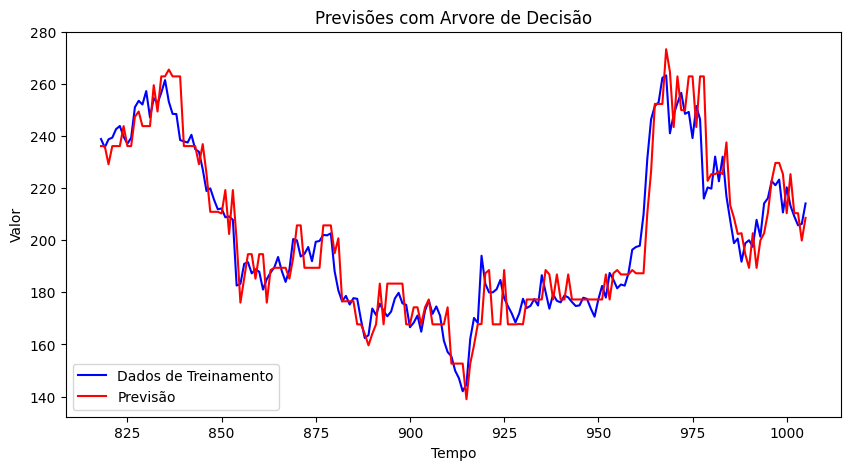

In [26]:
X_test_index = X_test_tesla.index

# Visualizando as previsões
plt.figure(figsize=(10, 5))
plt.plot(X_test_index , y_test_tesla, label='Dados de Treinamento', color='blue')
plt.plot(X_test_index , y_best_pred, label='Previsão', color='red')
plt.title('Previsões com Arvore de Decisão')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [27]:
print(f"Tempos de execução:\n Execução 1: {execution_time1}s Execução 2:{execution_time2}s")

Tempos de execução:
 Execução 1: 141.9838433265686s Execução 2:29.746989488601685s


In [28]:
train_size=60
test_size=20
def objective3(params):
    results = rolling_window_cross_validation(X_train_tesla, y_train_tesla, train_size, test_size, params)
    return results['mse']

In [29]:
start_time = time.time()
res3 = gp_minimize(objective3, space, n_calls=50, random_state=42)
end_time = time.time()
execution_time3 = end_time - start_time
print(f"Tempo de execução: {execution_time3} segundos")

Tempo de execução: 191.93050146102905 segundos


In [30]:
best_max_depth = int(res3.x[0])
best_min_samples_split = int(res3.x[1])
best_min_samples_leaf = int(res3.x[2])
best_max_features = res3.x[3]

print("Melhores hiperparâmetros encontrados:")
print(f"Max Depth: {best_max_depth}")
print(f"Min Samples Split: {best_min_samples_split}")
print(f"Min Samples Leaf: {best_min_samples_leaf}")
print(f"Max Features: {best_max_features}")

Melhores hiperparâmetros encontrados:
Max Depth: 35
Min Samples Split: 2
Min Samples Leaf: 6
Max Features: 1.0


In [31]:
best_model_3 = DecisionTreeRegressor(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features
)

best_model_3.fit(X_train_tesla, y_train_tesla)

# Fazer previsões com o melhor modelo
y_best_pred_3 = best_model_3.predict(X_test_tesla)

In [32]:
calcular_metricas_regressao(y_test_tesla, y_best_pred_3)

,Métrica,Valor
0,MAE,6.123072
1,MSE,63.868757
2,MAPE,0.030906
3,RMSE,7.991793
4,R²,0.927936
5,THEIL,1.278277
6,ARV,0.072064
7,WPOCID,0.294118


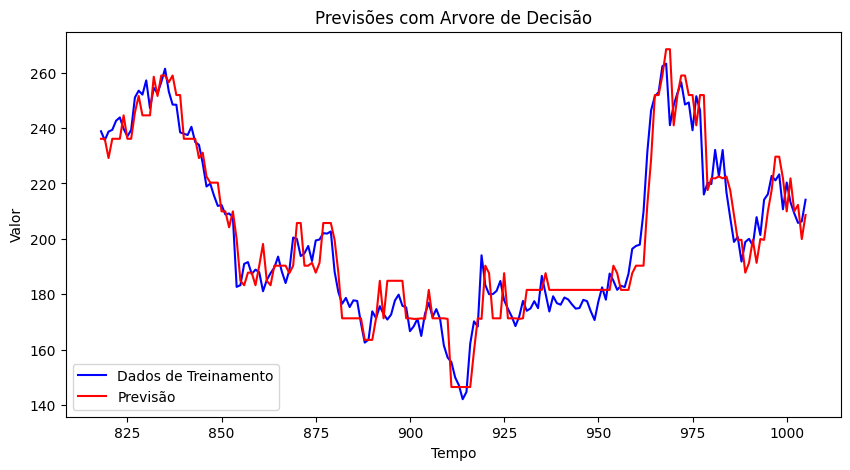

In [33]:
X_test_index = X_test_tesla.index

# Visualizando as previsões
plt.figure(figsize=(10, 5))
plt.plot(X_test_index , y_test_tesla, label='Dados de Treinamento', color='blue')
plt.plot(X_test_index , y_best_pred_3, label='Previsão', color='red')
plt.title('Previsões com Arvore de Decisão')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [34]:
train_size=60
test_size=20
buffer_size = 12
def objective4(params):
    results = blocked_cross_validation(X_train_tesla, y_train_tesla, train_size, test_size, buffer_size, params)
    return results['mse']

In [35]:
start_time = time.time()
res4 = gp_minimize(objective4, space, n_calls=50, random_state=42)
end_time = time.time()
execution_time4 = end_time - start_time
print(f"Tempo de execução: {execution_time4} segundos")

Tempo de execução: 180.38111186027527 segundos


In [36]:
best_max_depth = int(res4.x[0])
best_min_samples_split = int(res4.x[1])
best_min_samples_leaf = int(res4.x[2])
best_max_features = res4.x[3]

print("Melhores hiperparâmetros encontrados:")
print(f"Max Depth: {best_max_depth}")
print(f"Min Samples Split: {best_min_samples_split}")
print(f"Min Samples Leaf: {best_min_samples_leaf}")
print(f"Max Features: {best_max_features}")

Melhores hiperparâmetros encontrados:
Max Depth: 30
Min Samples Split: 12
Min Samples Leaf: 6
Max Features: 1.0


In [37]:
best_model_4 = DecisionTreeRegressor(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features
)

best_model_4.fit(X_train_tesla, y_train_tesla)

# Fazer previsões com o melhor modelo
y_best_pred_4 = best_model_4.predict(X_test_tesla)

In [38]:
calcular_metricas_regressao(y_test_tesla, y_best_pred_4)

,Métrica,Valor
0,MAE,6.123072
1,MSE,63.868757
2,MAPE,0.030906
3,RMSE,7.991793
4,R²,0.927936
5,THEIL,1.278277
6,ARV,0.072064
7,WPOCID,0.294118


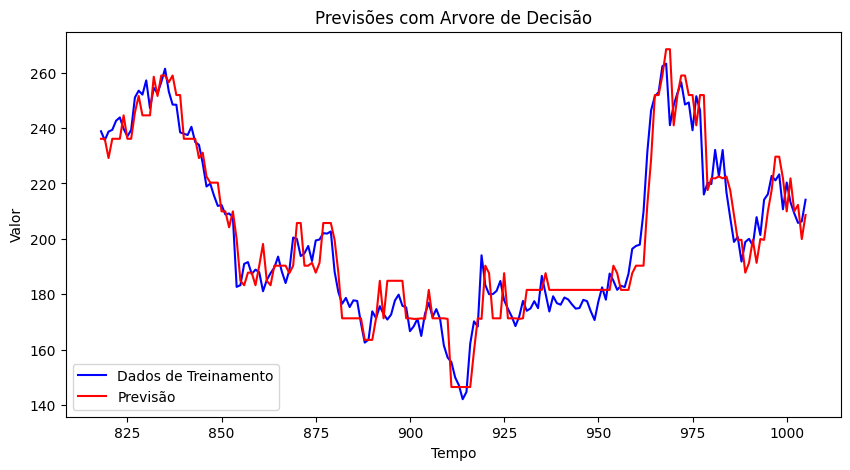

In [39]:
X_test_index = X_test_tesla.index

# Visualizando as previsões
plt.figure(figsize=(10, 5))
plt.plot(X_test_index , y_test_tesla, label='Dados de Treinamento', color='blue')
plt.plot(X_test_index , y_best_pred_4, label='Previsão', color='red')
plt.title('Previsões com Arvore de Decisão')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

## Comparação de Desempenho dos Modelos

Os resultados obtidos a partir das métricas aplicadas indicam que o Primeiro Modelo apresenta um desempenho superior ao Segundo Modelo em termos de precisão e capacidade explicativa dos dados. O Erro Médio Absoluto (MAE) e o Erro Percentual Absoluto Médio (MAPE) do Primeiro Modelo são menores, sugerindo que ele oferece previsões mais próximas dos valores reais e um erro percentual mais reduzido em relação ao Segundo Modelo. Essa precisão é corroborada pelo Erro Quadrático Médio (MSE) e pela Raiz do Erro Quadrático Médio (RMSE), que penalizam erros maiores, indicando que o Primeiro Modelo consegue reduzir erros grandes com mais eficácia.

Além disso, o Coeficiente de Determinação (R²) do Primeiro Modelo é superior, evidenciando que ele explica uma proporção maior da variabilidade dos dados, o que sugere uma modelagem mais robusta e ajustada. O Índice de Theil e o Valor Relativo Absoluto do Erro (ARV) também são menores no Primeiro Modelo, reforçando sua superioridade na precisão preditiva, ao passo que esses índices menores demonstram uma menor dispersão dos erros em comparação a uma linha de base.

Finalmente, o Índice de Previsão de Direção (WPOCID) é levemente mais alto para o Primeiro Modelo, indicando uma melhor capacidade de capturar a direção das mudanças dos valores previstos, uma característica relevante em previsões temporais. Em síntese, a análise comparativa sugere que o Primeiro Modelo não apenas reduz os erros absolutos e percentuais, mas também explica mais da variabilidade dos dados e fornece previsões de direção de forma mais confiável, tornando-o preferível para o contexto analisado.